In [1]:
# Set up inline plotting
get_ipython().run_line_magic('matplotlib', 'inline')
import copy
from time import time
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix
from torch import nn
from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

torch.manual_seed(2)
np.random.seed(3)
from argparse import ArgumentParser
from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

import copy
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix
from torch import nn
from torch.autograd import Variable
from torch.utils import data
from tqdm import tqdm

# Set random seeds
torch.manual_seed(2)
np.random.seed(3)

# Configure device
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Hardcode parameters directly in the Notebook to avoid argparse conflicts
class Args:
    batch_size = 32     # Originally -b/--batch-size
    workers = 20        # Originally -j/--workers
    epochs = 50         # Originally --epochs
    task = "davis"    # Originally --task
    lr = 1e-4           # Originally --lr

args = Args()

In [3]:
def get_task(task_name):
    if task_name.lower() == 'biosnap':
        return './dataset/BIOSNAP/full_data'
    elif task_name.lower() == 'bindingdb':
        return './dataset/BindingDB'
    elif task_name.lower() == 'davis':
        return './dataset/DAVIS'

def test(data_generator, model, threshold=None):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()

        label_var = Variable(torch.from_numpy(np.array(label)).float()).cuda()
        loss = loss_fct(logits, label_var)

        loss_accumulate += loss
        count += 1

        logits = logits.detach().cpu().numpy()
        label_ids = label_var.to('cpu').numpy() # Use label_var for consistency
        y_label += label_ids.flatten().tolist()
        y_pred += logits.flatten().tolist()

    loss = loss_accumulate / count

    fpr, tpr, thresholds = roc_curve(y_label, y_pred)
    precision = tpr / (tpr + fpr + 1e-10)
    f1 = 2 * precision * tpr / (tpr + precision + 1e-10)
    thred_optim = thresholds[5:][np.argmax(f1[5:])] if len(thresholds) > 5 else 0.5

    # Use the provided threshold or the automatically calculated one
    if threshold is None:
        threshold = thred_optim

    y_pred_labels = (np.asarray(y_pred) >= threshold).astype(int)
    auc_k = roc_auc_score(y_label, y_pred)
    auprc = average_precision_score(y_label, y_pred)
    f1_val = f1_score(y_label, y_pred_labels)

    return auc_k, auprc, f1_val, y_pred, loss.item(), thred_optim, y_label

In [4]:
def main():
    from config import BIN_config_DBPE
    from models import BIN_Interaction_Flat
    from stream import BIN_Data_Encoder

    config = BIN_config_DBPE()
    config['batch_size'] = args.batch_size

    # Initialize metric storage
    train_losses = []
    train_aucs = []  # Added: store training set AUC
    train_auprcs = [] # Added: store training set AUPRC
    train_f1s = []    # Added: store training set F1
    val_aucs = []
    val_auprcs = []
    val_f1s = []
    val_losses = []

    model = BIN_Interaction_Flat(**config).cuda()
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    opt = torch.optim.Adam(model.parameters(), lr=args.lr)

    # Data loading
    dataFolder = get_task(args.task)
    df_train = pd.read_csv(dataFolder + '/train.csv')
    df_val = pd.read_csv(dataFolder + '/val.csv')
    df_test = pd.read_csv(dataFolder + '/test.csv')

    params = {'batch_size': args.batch_size, 'shuffle': True,
              'num_workers': args.workers, 'drop_last': True}
    training_generator = data.DataLoader(BIN_Data_Encoder(df_train.index, df_train.Label, df_train),**params)
    validation_generator = data.DataLoader(BIN_Data_Encoder(df_val.index, df_val.Label, df_val),**params)
    testing_generator = data.DataLoader(BIN_Data_Encoder(df_test.index, df_test.Label, df_test),**params)

    # Early stopping mechanism
    max_auc = 0
    best_threshold = 0.5
    model_max = copy.deepcopy(model)

    print('\n--- Starting Training ---')
    for epoch in range(args.epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        batch_count = 0
        epoch_y_pred = []  # Added: collect predictions for the current epoch
        epoch_y_label = [] # Added: collect true labels for the current epoch
        progress_bar = tqdm(
            enumerate(training_generator),
            total=len(training_generator),
            desc=f'Epoch {epoch + 1}', # Use English description
            leave=True
        )
        for i, (d, p, d_mask, p_mask, label) in progress_bar:
            opt.zero_grad()

            score = model(d.long().cuda(), p.long().cuda(),
                          d_mask.long().cuda(), p_mask.long().cuda())
            m = torch.nn.Sigmoid()
            logits = torch.squeeze(m(score))

            label_var = Variable(torch.from_numpy(np.array(label)).float()).cuda() # Avoid conflict with outer label variable
            loss = torch.nn.BCELoss()(logits, label_var)

            loss.backward()
            opt.step()

            # Update progress bar information
            epoch_train_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg_loss': f'{epoch_train_loss / batch_count:.4f}'
            })

            # Collect predictions and labels for calculating epoch metrics
            epoch_y_pred.extend(logits.detach().cpu().numpy().flatten().tolist())
            epoch_y_label.extend(label.flatten().tolist()) # Use the original numpy label

        # Record training loss
        avg_train_loss = epoch_train_loss / batch_count
        train_losses.append(avg_train_loss)

        # Calculate training set metrics for the current epoch
        try:
            epoch_train_auc = roc_auc_score(epoch_y_label, epoch_y_pred)
            epoch_train_auprc = average_precision_score(epoch_y_label, epoch_y_pred)
            # Use 0.5 as the threshold for calculating training set F1
            epoch_train_pred_labels = (np.asarray(epoch_y_pred) >= 0.5).astype(int)
            epoch_train_f1 = f1_score(epoch_y_label, epoch_train_pred_labels)
            train_aucs.append(epoch_train_auc)
            train_auprcs.append(epoch_train_auprc)
            train_f1s.append(epoch_train_f1)
            print(f'Epoch {epoch + 1} Training   | AUC: {epoch_train_auc:.4f} | AUPRC: {epoch_train_auprc:.4f} | F1: {epoch_train_f1:.4f} | Loss: {avg_train_loss:.4f}')
        except ValueError as e:
            # Handle cases where metrics cannot be calculated (e.g., only one class predicted)
            print(f"Warning: Could not calculate training metrics for epoch {epoch + 1}: {e}")
            train_aucs.append(np.nan)
            train_auprcs.append(np.nan)
            train_f1s.append(np.nan)

        # Validation phase
        with torch.no_grad():
            auc_val, auprc_val, f1_val, _, val_loss, thred_optim, _ = test(validation_generator, model)
            val_aucs.append(auc_val)
            val_auprcs.append(auprc_val)
            val_f1s.append(f1_val)
            val_losses.append(val_loss)

            print(f'Epoch {epoch + 1} Validation | '
                  f'AUC: {auc_val:.4f} | AUPRC: {auprc_val:.4f} | '
                  f'F1: {f1_val:.4f} | Loss: {val_loss:.4f}')

            # Update the best model and threshold
            if auc_val > max_auc:
                max_auc = auc_val
                best_threshold = thred_optim
                model_max = copy.deepcopy(model)

    # Final testing and generate heatmap
    print('\n--- Final Testing ---')
    with torch.no_grad():
        test_auc, test_auprc, test_f1, y_pred, test_loss, _, y_true = test(testing_generator, model_max,
                                                                           threshold=best_threshold)

        # Generate confusion matrix heatmap
        y_pred_labels = (np.array(y_pred) >= best_threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred_labels)
        plt.figure(figsize=(8, 6)) # Adjust heatmap size
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted Negative', 'Predicted Positive'], 
                    yticklabels=['Actual Negative', 'Actual Positive'])
        plt.title('Confusion Matrix Heatmap')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix_heatmap.png')
        plt.show()

        print(f'Test Results | AUC: {test_auc:.4f} | AUPRC: {test_auprc:.4f} | '
              f'F1: {test_f1:.4f} | Loss: {test_loss:.4f}')

    # Plot training curves
    plt.figure(figsize=(15, 10))

    # Loss curve
    plt.subplot(2, 3, 1)
    plt.plot(range(1, args.epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, args.epochs + 1), val_losses, label='Validation Loss')
    plt.scatter(args.epochs, test_loss, color='red', marker='*', s=100, label='Test Loss', zorder=5)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # AUC curve
    plt.subplot(2, 3, 2)
    plt.plot(range(1, args.epochs + 1), train_aucs, label='Training AUC')
    plt.plot(range(1, args.epochs + 1), val_aucs, color='orange', label='Validation AUC')
    plt.scatter(args.epochs, test_auc, color='red', marker='*', s=100, label='Test AUC', zorder=5)
    plt.title('AUC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True)

    # AUPRC curve
    plt.subplot(2, 3, 3)
    plt.plot(range(1, args.epochs + 1), train_auprcs, label='Training AUPRC')
    plt.plot(range(1, args.epochs + 1), val_auprcs, color='green', label='Validation AUPRC')
    plt.scatter(args.epochs, test_auprc, color='red', marker='*', s=100, label='Test AUPRC', zorder=5)
    plt.title('AUPRC Curve')
    plt.xlabel('Epochs')
    plt.ylabel('AUPRC')
    plt.legend()
    plt.grid(True)

    # F1 score curve
    plt.subplot(2, 3, 4)
    plt.plot(range(1, args.epochs + 1), train_f1s, label='Training F1 Score')
    plt.plot(range(1, args.epochs + 1), val_f1s, color='red', label='Validation F1 Score')
    plt.scatter(args.epochs, test_f1, color='blue', marker='*', s=100, label='Test F1 Score', zorder=5)
    plt.title('F1 Score Curve')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

    # --- Save model to H5 file ---
    print('\n--- Saving Model to H5 ---')
    import h5py
    import os

    save_dir = 'saved_models'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model_path = os.path.join(save_dir, f'model_{args.task}.h5')

    # Get model state dictionary and move to CPU
    model_to_save = model_max.module if isinstance(model_max, nn.DataParallel) else model_max
    cpu_state_dict = {k: v.cpu() for k, v in model_to_save.state_dict().items()}

    try:
        with h5py.File(model_path, 'w') as f:
            # Save hyperparameters (from args object)
            hparams_group = f.create_group('hyperparameters')
            for key, value in vars(args).items():
                # h5py does not support saving None or complex objects, convert to string
                hparams_group.attrs[key] = str(value)
            
            # Save model configuration (from model object, if it exists)
            if hasattr(model_to_save, 'config') and isinstance(model_to_save.config, dict):
                config_group = f.create_group('config')
                for key, value in model_to_save.config.items():
                    # Also convert to string
                    config_group.attrs[key] = str(value)
            else:
                print("Model config not found or not a dict, skipping config saving.")
            
            # Save model weights
            weights_group = f.create_group('weights')
            for name, param_np in cpu_state_dict.items():
                weights_group.create_dataset(name, data=param_np.numpy())
            
        print(f"Model successfully saved to: {model_path}")
    except Exception as e:
        print(f"Error saving model to H5: {e}")
    # --- Model saving finished ---

    return model_max


--- Starting Training ---


Epoch 1: 100%|██████████| 65/65 [00:12<00:00,  5.35it/s, loss=0.5140, avg_loss=0.5769]

Epoch 1 Training   | AUC: 0.7855 | AUPRC: 0.7716 | F1: 0.7299 | Loss: 0.5769


Epoch 1 Validation | AUC: 0.8491 | AUPRC: 0.2872 | F1: 0.2144 | Loss: 0.4924


Epoch 2: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, loss=0.4123, avg_loss=0.5263]

Epoch 2 Training   | AUC: 0.8289 | AUPRC: 0.8132 | F1: 0.7662 | Loss: 0.5263


Epoch 2 Validation | AUC: 0.8337 | AUPRC: 0.2542 | F1: 0.2159 | Loss: 0.4431


Epoch 3: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s, loss=0.5676, avg_loss=0.4806]

Epoch 3 Training   | AUC: 0.8563 | AUPRC: 0.8393 | F1: 0.7870 | Loss: 0.4806


Epoch 3 Validation | AUC: 0.8613 | AUPRC: 0.3145 | F1: 0.2554 | Loss: 0.5938


Epoch 4: 100%|██████████| 65/65 [00:11<00:00,  5.70it/s, loss=0.3363, avg_loss=0.4394]

Epoch 4 Training   | AUC: 0.8834 | AUPRC: 0.8680 | F1: 0.8135 | Loss: 0.4394


Epoch 4 Validation | AUC: 0.8537 | AUPRC: 0.2884 | F1: 0.2367 | Loss: 0.5832


Epoch 5: 100%|██████████| 65/65 [00:11<00:00,  5.50it/s, loss=0.5116, avg_loss=0.5019]

Epoch 5 Training   | AUC: 0.8335 | AUPRC: 0.8393 | F1: 0.7515 | Loss: 0.5019


Epoch 5 Validation | AUC: 0.7105 | AUPRC: 0.1591 | F1: 0.1256 | Loss: 0.2756


Epoch 6: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, loss=0.5587, avg_loss=0.5294]

Epoch 6 Training   | AUC: 0.8151 | AUPRC: 0.8069 | F1: 0.7489 | Loss: 0.5294


Epoch 6 Validation | AUC: 0.8379 | AUPRC: 0.2790 | F1: 0.2023 | Loss: 0.4106


Epoch 7: 100%|██████████| 65/65 [00:11<00:00,  5.89it/s, loss=0.5267, avg_loss=0.4717]

Epoch 7 Training   | AUC: 0.8578 | AUPRC: 0.8484 | F1: 0.7861 | Loss: 0.4717


Epoch 7 Validation | AUC: 0.8506 | AUPRC: 0.3125 | F1: 0.2198 | Loss: 0.3653


Epoch 8: 100%|██████████| 65/65 [00:11<00:00,  5.64it/s, loss=0.3951, avg_loss=0.4341]

Epoch 8 Training   | AUC: 0.8815 | AUPRC: 0.8717 | F1: 0.8050 | Loss: 0.4341


Epoch 8 Validation | AUC: 0.8772 | AUPRC: 0.3682 | F1: 0.2565 | Loss: 0.3914


Epoch 9: 100%|██████████| 65/65 [00:12<00:00,  5.34it/s, loss=0.3971, avg_loss=0.3976]

Epoch 9 Training   | AUC: 0.9036 | AUPRC: 0.8940 | F1: 0.8383 | Loss: 0.3976


Epoch 9 Validation | AUC: 0.8807 | AUPRC: 0.3358 | F1: 0.2721 | Loss: 0.4331


Epoch 10: 100%|██████████| 65/65 [00:11<00:00,  5.89it/s, loss=0.5792, avg_loss=0.4247]

Epoch 10 Training   | AUC: 0.8866 | AUPRC: 0.8775 | F1: 0.8009 | Loss: 0.4247


Epoch 10 Validation | AUC: 0.7805 | AUPRC: 0.1960 | F1: 0.1718 | Loss: 0.1960


Epoch 11: 100%|██████████| 65/65 [00:11<00:00,  5.47it/s, loss=0.4394, avg_loss=0.5177]

Epoch 11 Training   | AUC: 0.8234 | AUPRC: 0.8125 | F1: 0.7466 | Loss: 0.5177


Epoch 11 Validation | AUC: 0.8481 | AUPRC: 0.2922 | F1: 0.2747 | Loss: 1.0809


Epoch 12: 100%|██████████| 65/65 [00:11<00:00,  5.73it/s, loss=0.3759, avg_loss=0.4560]

Epoch 12 Training   | AUC: 0.8667 | AUPRC: 0.8566 | F1: 0.8024 | Loss: 0.4560


Epoch 12 Validation | AUC: 0.8510 | AUPRC: 0.3064 | F1: 0.2181 | Loss: 0.7621


Epoch 13: 100%|██████████| 65/65 [00:11<00:00,  5.67it/s, loss=0.5118, avg_loss=0.4185]

Epoch 13 Training   | AUC: 0.8905 | AUPRC: 0.8830 | F1: 0.8099 | Loss: 0.4185


Epoch 13 Validation | AUC: 0.8501 | AUPRC: 0.2969 | F1: 0.3039 | Loss: 0.6640


Epoch 14: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, loss=0.3154, avg_loss=0.3888]

Epoch 14 Training   | AUC: 0.9049 | AUPRC: 0.8982 | F1: 0.8277 | Loss: 0.3888


Epoch 14 Validation | AUC: 0.8547 | AUPRC: 0.3292 | F1: 0.2311 | Loss: 0.8256


Epoch 15: 100%|██████████| 65/65 [00:11<00:00,  5.44it/s, loss=0.3965, avg_loss=0.3812]

Epoch 15 Training   | AUC: 0.9088 | AUPRC: 0.8981 | F1: 0.8381 | Loss: 0.3812


Epoch 15 Validation | AUC: 0.8628 | AUPRC: 0.3393 | F1: 0.3150 | Loss: 0.7189


Epoch 16: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, loss=0.3886, avg_loss=0.3530]

Epoch 16 Training   | AUC: 0.9236 | AUPRC: 0.9162 | F1: 0.8456 | Loss: 0.3530


Epoch 16 Validation | AUC: 0.8717 | AUPRC: 0.3455 | F1: 0.2489 | Loss: 0.5110


Epoch 17: 100%|██████████| 65/65 [00:11<00:00,  5.61it/s, loss=0.3098, avg_loss=0.3417]

Epoch 17 Training   | AUC: 0.9281 | AUPRC: 0.9168 | F1: 0.8570 | Loss: 0.3417


Epoch 17 Validation | AUC: 0.8768 | AUPRC: 0.3802 | F1: 0.2432 | Loss: 0.3362


Epoch 18: 100%|██████████| 65/65 [00:11<00:00,  5.42it/s, loss=0.3640, avg_loss=0.3308]

Epoch 18 Training   | AUC: 0.9338 | AUPRC: 0.9281 | F1: 0.8632 | Loss: 0.3308


Epoch 18 Validation | AUC: 0.8564 | AUPRC: 0.2627 | F1: 0.2032 | Loss: 0.3595


Epoch 19: 100%|██████████| 65/65 [00:11<00:00,  5.64it/s, loss=0.3542, avg_loss=0.3204]

Epoch 19 Training   | AUC: 0.9378 | AUPRC: 0.9320 | F1: 0.8557 | Loss: 0.3204


Epoch 19 Validation | AUC: 0.8791 | AUPRC: 0.3426 | F1: 0.2456 | Loss: 0.5442


Epoch 20: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, loss=0.2513, avg_loss=0.3614]

Epoch 20 Training   | AUC: 0.9164 | AUPRC: 0.9065 | F1: 0.8380 | Loss: 0.3614


Epoch 20 Validation | AUC: 0.8614 | AUPRC: 0.3160 | F1: 0.2825 | Loss: 0.3363


Epoch 21: 100%|██████████| 65/65 [00:11<00:00,  5.71it/s, loss=0.3633, avg_loss=0.3621]

Epoch 21 Training   | AUC: 0.9176 | AUPRC: 0.9085 | F1: 0.8392 | Loss: 0.3621


Epoch 21 Validation | AUC: 0.8756 | AUPRC: 0.3513 | F1: 0.3647 | Loss: 0.5111


Epoch 22: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, loss=0.3035, avg_loss=0.3226]

Epoch 22 Training   | AUC: 0.9370 | AUPRC: 0.9310 | F1: 0.8585 | Loss: 0.3226


Epoch 22 Validation | AUC: 0.8826 | AUPRC: 0.3604 | F1: 0.3917 | Loss: 0.5111


Epoch 23: 100%|██████████| 65/65 [00:11<00:00,  5.73it/s, loss=0.4637, avg_loss=0.2916]

Epoch 23 Training   | AUC: 0.9486 | AUPRC: 0.9426 | F1: 0.8758 | Loss: 0.2916


Epoch 23 Validation | AUC: 0.8801 | AUPRC: 0.3376 | F1: 0.2845 | Loss: 0.6021


Epoch 24: 100%|██████████| 65/65 [00:11<00:00,  5.60it/s, loss=0.3255, avg_loss=0.2839]

Epoch 24 Training   | AUC: 0.9519 | AUPRC: 0.9486 | F1: 0.8786 | Loss: 0.2839


Epoch 24 Validation | AUC: 0.8679 | AUPRC: 0.2385 | F1: 0.2641 | Loss: 2.7976


Epoch 25: 100%|██████████| 65/65 [00:12<00:00,  5.39it/s, loss=0.2340, avg_loss=0.2649]

Epoch 25 Training   | AUC: 0.9592 | AUPRC: 0.9552 | F1: 0.8880 | Loss: 0.2649


Epoch 25 Validation | AUC: 0.8896 | AUPRC: 0.3738 | F1: 0.2902 | Loss: 0.3355


Epoch 26: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, loss=0.2501, avg_loss=0.2482]

Epoch 26 Training   | AUC: 0.9648 | AUPRC: 0.9642 | F1: 0.8956 | Loss: 0.2482


Epoch 26 Validation | AUC: 0.8828 | AUPRC: 0.3211 | F1: 0.2401 | Loss: 0.9819


Epoch 27: 100%|██████████| 65/65 [00:11<00:00,  5.58it/s, loss=0.3710, avg_loss=0.2380]

Epoch 27 Training   | AUC: 0.9670 | AUPRC: 0.9655 | F1: 0.8991 | Loss: 0.2380


Epoch 27 Validation | AUC: 0.8736 | AUPRC: 0.3236 | F1: 0.2520 | Loss: 0.7141


Epoch 28: 100%|██████████| 65/65 [00:11<00:00,  5.83it/s, loss=0.2693, avg_loss=0.2320]

Epoch 28 Training   | AUC: 0.9691 | AUPRC: 0.9679 | F1: 0.8935 | Loss: 0.2320


Epoch 28 Validation | AUC: 0.8872 | AUPRC: 0.3054 | F1: 0.2367 | Loss: 0.7458


Epoch 29: 100%|██████████| 65/65 [00:11<00:00,  5.74it/s, loss=0.2803, avg_loss=0.2030]

Epoch 29 Training   | AUC: 0.9775 | AUPRC: 0.9772 | F1: 0.9196 | Loss: 0.2030


Epoch 29 Validation | AUC: 0.8798 | AUPRC: 0.3077 | F1: 0.3084 | Loss: 1.0069


Epoch 30: 100%|██████████| 65/65 [00:11<00:00,  5.67it/s, loss=0.2688, avg_loss=0.2115]

Epoch 30 Training   | AUC: 0.9748 | AUPRC: 0.9728 | F1: 0.9165 | Loss: 0.2115


Epoch 30 Validation | AUC: 0.7871 | AUPRC: 0.1872 | F1: 0.1893 | Loss: 0.2843


Epoch 31: 100%|██████████| 65/65 [00:12<00:00,  5.38it/s, loss=0.3135, avg_loss=0.4007]

Epoch 31 Training   | AUC: 0.8996 | AUPRC: 0.8963 | F1: 0.8213 | Loss: 0.4007


Epoch 31 Validation | AUC: 0.8783 | AUPRC: 0.3395 | F1: 0.3608 | Loss: 0.8333


Epoch 32: 100%|██████████| 65/65 [00:11<00:00,  5.72it/s, loss=0.3429, avg_loss=0.3275]

Epoch 32 Training   | AUC: 0.9327 | AUPRC: 0.9285 | F1: 0.8555 | Loss: 0.3275


Epoch 32 Validation | AUC: 0.8782 | AUPRC: 0.3162 | F1: 0.2805 | Loss: 0.3896


Epoch 33: 100%|██████████| 65/65 [00:11<00:00,  5.49it/s, loss=0.3252, avg_loss=0.2780]

Epoch 33 Training   | AUC: 0.9523 | AUPRC: 0.9498 | F1: 0.8800 | Loss: 0.2780


Epoch 33 Validation | AUC: 0.8803 | AUPRC: 0.3055 | F1: 0.3217 | Loss: 0.3959


Epoch 34: 100%|██████████| 65/65 [00:11<00:00,  5.72it/s, loss=0.3435, avg_loss=0.2365]

Epoch 34 Training   | AUC: 0.9665 | AUPRC: 0.9630 | F1: 0.9070 | Loss: 0.2365


Epoch 34 Validation | AUC: 0.8769 | AUPRC: 0.3245 | F1: 0.2308 | Loss: 0.6471


Epoch 35: 100%|██████████| 65/65 [00:11<00:00,  5.88it/s, loss=0.3208, avg_loss=0.2357]

Epoch 35 Training   | AUC: 0.9661 | AUPRC: 0.9644 | F1: 0.9035 | Loss: 0.2357


Epoch 35 Validation | AUC: 0.8841 | AUPRC: 0.2617 | F1: 0.2718 | Loss: 1.3084


Epoch 36: 100%|██████████| 65/65 [00:11<00:00,  5.54it/s, loss=0.2200, avg_loss=0.1979]

Epoch 36 Training   | AUC: 0.9776 | AUPRC: 0.9750 | F1: 0.9177 | Loss: 0.1979


Epoch 36 Validation | AUC: 0.8954 | AUPRC: 0.3030 | F1: 0.3167 | Loss: 1.0273


Epoch 37: 100%|██████████| 65/65 [00:11<00:00,  5.87it/s, loss=0.1804, avg_loss=0.2171]

Epoch 37 Training   | AUC: 0.9720 | AUPRC: 0.9706 | F1: 0.9143 | Loss: 0.2171


Epoch 37 Validation | AUC: 0.8963 | AUPRC: 0.3494 | F1: 0.2908 | Loss: 0.8166


Epoch 38: 100%|██████████| 65/65 [00:11<00:00,  5.49it/s, loss=0.1444, avg_loss=0.1907]

Epoch 38 Training   | AUC: 0.9801 | AUPRC: 0.9799 | F1: 0.9244 | Loss: 0.1907


Epoch 38 Validation | AUC: 0.8952 | AUPRC: 0.3560 | F1: 0.2949 | Loss: 0.6664


Epoch 39: 100%|██████████| 65/65 [00:10<00:00,  5.93it/s, loss=0.2340, avg_loss=0.2749]

Epoch 39 Training   | AUC: 0.9532 | AUPRC: 0.9507 | F1: 0.8873 | Loss: 0.2749


Epoch 39 Validation | AUC: 0.8600 | AUPRC: 0.3128 | F1: 0.2289 | Loss: 0.5547


Epoch 40: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, loss=0.2379, avg_loss=0.2507]

Epoch 40 Training   | AUC: 0.9616 | AUPRC: 0.9607 | F1: 0.8925 | Loss: 0.2507


Epoch 40 Validation | AUC: 0.8871 | AUPRC: 0.3391 | F1: 0.3217 | Loss: 0.4979


Epoch 41: 100%|██████████| 65/65 [00:10<00:00,  6.01it/s, loss=0.2161, avg_loss=0.2031]

Epoch 41 Training   | AUC: 0.9755 | AUPRC: 0.9748 | F1: 0.9212 | Loss: 0.2031


Epoch 41 Validation | AUC: 0.8869 | AUPRC: 0.3205 | F1: 0.2660 | Loss: 0.7908


Epoch 42: 100%|██████████| 65/65 [00:11<00:00,  5.86it/s, loss=0.1778, avg_loss=0.1796]

Epoch 42 Training   | AUC: 0.9816 | AUPRC: 0.9805 | F1: 0.9312 | Loss: 0.1796


Epoch 42 Validation | AUC: 0.9022 | AUPRC: 0.4100 | F1: 0.3503 | Loss: 0.5698


Epoch 43: 100%|██████████| 65/65 [00:11<00:00,  5.63it/s, loss=0.0793, avg_loss=0.1629]

Epoch 43 Training   | AUC: 0.9852 | AUPRC: 0.9846 | F1: 0.9311 | Loss: 0.1629


Epoch 43 Validation | AUC: 0.8816 | AUPRC: 0.3234 | F1: 0.2709 | Loss: 0.6989


Epoch 44: 100%|██████████| 65/65 [00:11<00:00,  5.57it/s, loss=0.1862, avg_loss=0.1484]

Epoch 44 Training   | AUC: 0.9876 | AUPRC: 0.9869 | F1: 0.9416 | Loss: 0.1484


Epoch 44 Validation | AUC: 0.8933 | AUPRC: 0.2922 | F1: 0.3002 | Loss: 1.3061


Epoch 45: 100%|██████████| 65/65 [00:11<00:00,  5.75it/s, loss=0.1408, avg_loss=0.1534]

Epoch 45 Training   | AUC: 0.9854 | AUPRC: 0.9837 | F1: 0.9440 | Loss: 0.1534


Epoch 45 Validation | AUC: 0.8752 | AUPRC: 0.2962 | F1: 0.3199 | Loss: 0.3791


Epoch 46: 100%|██████████| 65/65 [00:11<00:00,  5.46it/s, loss=0.8015, avg_loss=0.2506]

Epoch 46 Training   | AUC: 0.9619 | AUPRC: 0.9612 | F1: 0.8924 | Loss: 0.2506


Epoch 46 Validation | AUC: 0.7992 | AUPRC: 0.2378 | F1: 0.1839 | Loss: 0.8571


Epoch 47: 100%|██████████| 65/65 [00:11<00:00,  5.64it/s, loss=0.3659, avg_loss=0.4205]

Epoch 47 Training   | AUC: 0.8882 | AUPRC: 0.8874 | F1: 0.7994 | Loss: 0.4205


Epoch 47 Validation | AUC: 0.8634 | AUPRC: 0.2801 | F1: 0.2575 | Loss: 0.5670


Epoch 48: 100%|██████████| 65/65 [00:11<00:00,  5.83it/s, loss=0.2228, avg_loss=0.3095]

Epoch 48 Training   | AUC: 0.9407 | AUPRC: 0.9395 | F1: 0.8542 | Loss: 0.3095


Epoch 48 Validation | AUC: 0.8366 | AUPRC: 0.2366 | F1: 0.2616 | Loss: 1.9910


Epoch 49: 100%|██████████| 65/65 [00:11<00:00,  5.69it/s, loss=0.3148, avg_loss=0.2242]

Epoch 49 Training   | AUC: 0.9692 | AUPRC: 0.9676 | F1: 0.9067 | Loss: 0.2242


Epoch 49 Validation | AUC: 0.7445 | AUPRC: 0.1613 | F1: 0.2308 | Loss: 2.1868


Epoch 50: 100%|██████████| 65/65 [00:11<00:00,  5.78it/s, loss=0.4241, avg_loss=0.3223]

Epoch 50 Training   | AUC: 0.9368 | AUPRC: 0.9347 | F1: 0.8629 | Loss: 0.3223


Epoch 50 Validation | AUC: 0.8781 | AUPRC: 0.3574 | F1: 0.2455 | Loss: 0.7181

--- Final Testing ---


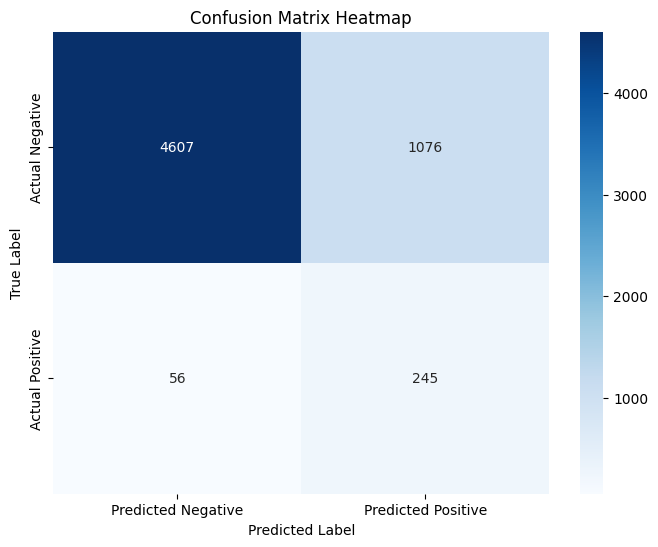

Test Results | AUC: 0.8914 | AUPRC: 0.3625 | F1: 0.3021 | Loss: 0.6154


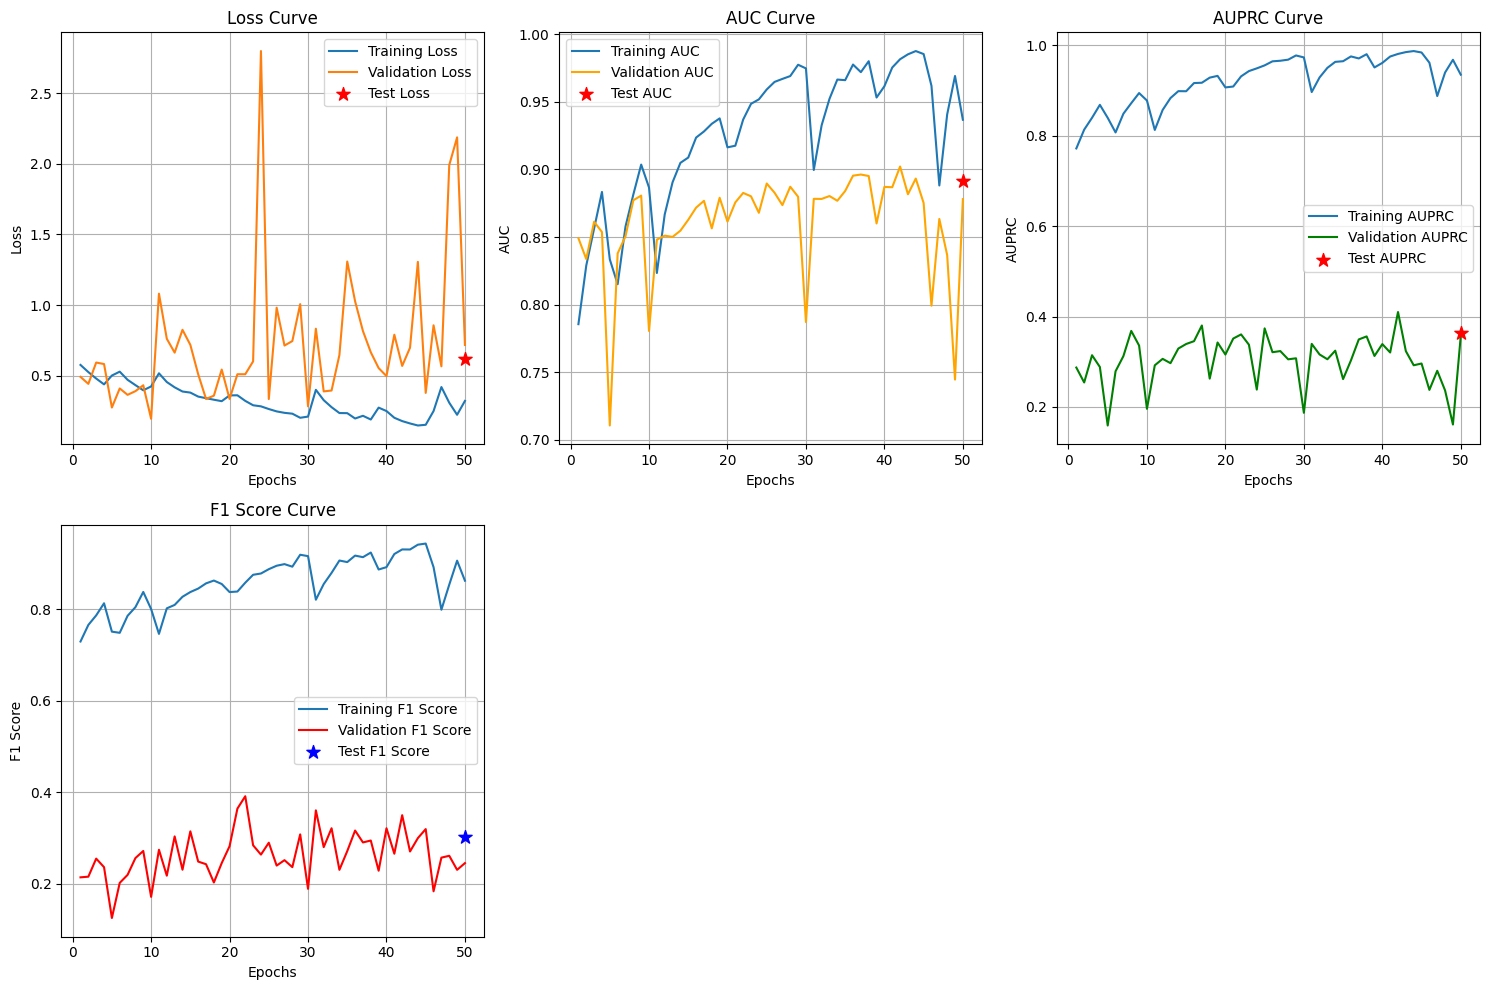


--- Saving Model to H5 ---
Model config not found or not a dict, skipping config saving.
Model successfully saved to: saved_models/model_davis.h5
Total time: 1271.63 seconds


In [5]:
start_time = time()
best_model = main()
print(f'Total time: {time() - start_time:.2f} seconds')

In [6]:
def shap_explainer(model, test_generator, num_samples=10):
    """
    Use SHAP for model interpretability analysis and visualization
    
    Args:
        model: Trained model
        test_generator: Test data generator
        num_samples: Number of samples to analyze
    """
    import shap
    import scipy.special as sp
    import time
    from tqdm.auto import tqdm
    
    plt.style.use('default')
    plt.rcParams.update({'font.size': 14})
    
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print(f"Using device for SHAP analysis: {device}")
    
    model = model.to(device)
    model.eval()
    
    print("Preparing data for SHAP analysis...")
    start_time = time.time()
    
    # Collect sample data for analysis
    all_d = []
    all_p = []
    all_d_mask = []
    all_p_mask = []
    labels = []
    
    # Extract sample data
    with torch.no_grad():
        for i, (d, p, d_mask, p_mask, label) in enumerate(test_generator):
            if i >= num_samples:
                break
                
            # Add samples from each batch
            for j in range(len(d)):
                all_d.append(d[j].to(device))
                all_p.append(p[j].to(device))
                all_d_mask.append(d_mask[j].to(device))
                all_p_mask.append(p_mask[j].to(device))
                labels.append(label[j].item())
    
    # Get sequence lengths
    drug_seq_len = len(all_d[0])
    protein_seq_len = len(all_p[0])
    
    # Calculate total number of features
    num_features = drug_seq_len + protein_seq_len
    
    print(f"Drug sequence length: {drug_seq_len}, Protein sequence length: {protein_seq_len}")
    print(f"Total number of features: {num_features}")
    print(f"Collected {len(all_d)} samples for analysis")
    
    # Create feature names
    feature_names = []
    # Drug features
    for i in range(drug_seq_len):
        feature_names.append(f"Drug_Pos_{i}")
    # Protein features
    for i in range(protein_seq_len):
        feature_names.append(f"Protein_Pos_{i}")
    
    print("Calculating feature importance - using GPU acceleration...")
    
    # Set parameters required for SHAP analysis
    num_analyze = min(5, len(all_d))
    
    # Create real background data
    print("Preparing background data...")
    background_size = min(len(all_d), 5)  # Use fewer background samples
    background_data = np.zeros((background_size, num_features))
    
    for i in range(background_size):
        # Combine drug and protein data into a single feature vector
        background_data[i, :drug_seq_len] = all_d[i].cpu().numpy()
        background_data[i, drug_seq_len:] = all_p[i].cpu().numpy()
    
    # Prepare instances to explain (choose samples different from background data)
    instances_data = np.zeros((num_analyze, num_features))
    for i in range(num_analyze):
        # Use samples different from background data
        idx = min(i + background_size, len(all_d) - 1)
        instances_data[i, :drug_seq_len] = all_d[idx].cpu().numpy()
        instances_data[i, drug_seq_len:] = all_p[idx].cpu().numpy()
    
    # Calculate original predictions for display in results
    predictions = []
    with torch.no_grad():
        for i in range(num_analyze):
            idx = min(i + background_size, len(all_d) - 1)
            output = model(all_d[idx].unsqueeze(0), all_p[idx].unsqueeze(0),
                          all_d_mask[idx].unsqueeze(0), all_p_mask[idx].unsqueeze(0))
            sigmoid_output = torch.sigmoid(output)
            if sigmoid_output.numel() == 1:
                predictions.append(sigmoid_output.item())
            else:
                predictions.append(sigmoid_output.mean().item())
    
    # Key to solving dimension mismatch - use a specific model wrapper
    def model_wrapper(masker_x):
        """
        Important: This model wrapper function must ensure it returns results of the same length as the input
        masker_x: Input data, could be background data or its perturbed versions
        """
        with torch.no_grad():
            # Get the current input batch size
            current_batch_size = masker_x.shape[0]
            
            # Ensure the result array matches the input batch size
            results = np.zeros(current_batch_size)
            
            # Process each input sample
            for i in range(current_batch_size):
                x_single = masker_x[i:i+1]  # Take a single sample, keep 2D shape
                
                # Convert input from NumPy array to PyTorch tensor
                x_tensor = torch.tensor(x_single, dtype=torch.float32).to(device)
                
                # Separate drug and protein data
                input_d = x_tensor[:, :drug_seq_len].long()
                input_p = x_tensor[:, drug_seq_len:].long()
                
                # Create masks (all ones)
                input_d_mask = torch.ones((1, drug_seq_len), device=device).long()
                input_p_mask = torch.ones((1, protein_seq_len), device=device).long()
                
                # Run the model
                output = model(input_d, input_p, input_d_mask, input_p_mask)
                
                # Apply sigmoid and ensure it's a scalar
                sigmoid_output = torch.sigmoid(output)
                
                # Extract the scalar value
                if sigmoid_output.numel() == 1:
                    results[i] = sigmoid_output.item()
                else:
                    results[i] = sigmoid_output.mean().item()
            
            return results
    
    # Use KernelExplainer (most reliable and compatible with any model)
    print("Calculating SHAP values using KernelExplainer...")
    
    # First test the model wrapper to ensure the output shape is correct
    print("Validating model output...")
    test_out = model_wrapper(background_data)
    print(f"Background data shape: {background_data.shape}")
    print(f"Model output shape: {test_out.shape}")
    
    # Ensure the output matches the background data length
    if len(test_out) != len(background_data):
        raise ValueError(f"Model output length {len(test_out)} does not match background data length {len(background_data)}!")
    
    try:
        # Create KernelExplainer using the validated model wrapper
        explainer = shap.KernelExplainer(
            model_wrapper, 
            background_data,
            link='identity'
        )
        
        # Use a larger nsamples value for better accuracy, but not too large to avoid GPU memory issues
        print("Calculating sample SHAP values (using GPU acceleration)...")
        shap_values = explainer.shap_values(instances_data, nsamples=200)
        
        # Ensure SHAP values are a numpy array
        if not isinstance(shap_values, np.ndarray):
            shap_values = np.array(shap_values)
        
        # Ensure SHAP values have the correct dimensions [num_samples, num_features]
        if len(shap_values.shape) > 2:
            shap_values = shap_values.reshape(shap_values.shape[0], -1)
            
    except Exception as e:
        print(f"SHAP calculation failed: {str(e)}")
        print("Attempting DeepExplainer alternative...")
        
        # Create special background and instance tensors
        background_tensor_d = torch.stack([d for d in all_d[:background_size]])
        background_tensor_p = torch.stack([p for p in all_p[:background_size]])
        background_tensor_d_mask = torch.stack([m for m in all_d_mask[:background_size]])
        background_tensor_p_mask = torch.stack([m for m in all_p_mask[:background_size]])
        
        instance_tensor_d = torch.stack([all_d[min(i + background_size, len(all_d) - 1)] for i in range(num_analyze)])
        instance_tensor_p = torch.stack([all_p[min(i + background_size, len(all_p) - 1)] for i in range(num_analyze)])
        instance_tensor_d_mask = torch.stack([all_d_mask[min(i + background_size, len(all_d_mask) - 1)] for i in range(num_analyze)])
        instance_tensor_p_mask = torch.stack([all_p_mask[min(i + background_size, len(all_p_mask) - 1)] for i in range(num_analyze)])
        
        try:
            # Define a special wrapper model function
            def wrapped_model(d, p):
                return torch.sigmoid(model(d, p, 
                                          torch.ones((d.shape[0], drug_seq_len), device=device).long(),
                                          torch.ones((p.shape[0], protein_seq_len), device=device).long()))
            
            # Create DeepExplainer
            explainer = shap.DeepExplainer(wrapped_model, 
                                          [background_tensor_d, background_tensor_p])
            
            # Calculate SHAP values
            shap_values_list = explainer.shap_values([instance_tensor_d, instance_tensor_p])
            
            # Process SHAP values for drug and protein
            drug_shap = shap_values_list[0]
            protein_shap = shap_values_list[1]
            
            # Combine SHAP values into a single unified array
            combined_shap = []
            for i in range(len(drug_shap)):
                combined_shap.append(np.concatenate([drug_shap[i].flatten(), protein_shap[i].flatten()]))
            
            shap_values = np.array(combined_shap)
        
        except Exception as deep_e:
            print(f"DeepExplainer also failed: {str(deep_e)}")
            print("Falling back to manual feature importance calculation...")
            
            # Create a simple feature importance matrix
            shap_values = np.zeros((num_analyze, num_features))
            
            # For each sample to analyze
            for i in range(num_analyze):
                # Get the baseline prediction
                idx = min(i + background_size, len(all_d) - 1)
                baseline_pred = predictions[i]
                
                # For each feature, calculate simple perturbation importance
                for j in range(num_features):
                    # Create a perturbed copy
                    perturbed_instance = instances_data[i].copy()
                    
                    # Perturb the feature (set to 0 or mean)
                    if j < drug_seq_len:
                        # Drug feature
                        # orig_val = perturbed_instance[j]
                        perturbed_instance[j] = 0  # Or use the mean of background data
                    else:
                        # Protein feature
                        # orig_val = perturbed_instance[j]
                        perturbed_instance[j] = 0  # Or use the mean of background data
                    
                    # Calculate prediction after perturbation
                    perturbed_pred = model_wrapper(perturbed_instance.reshape(1, -1))[0]
                    
                    # Calculate feature importance (prediction difference)
                    shap_values[i, j] = baseline_pred - perturbed_pred
            
            # Create a simple Explainer object containing only expected_value
            class SimpleExplainer:
                def __init__(self, expected_value):
                    self.expected_value = expected_value
            
            # Use the average prediction as the baseline value
            explainer = SimpleExplainer(np.mean(predictions))
    
    # Calculate time
    elapsed_time = time.time() - start_time
    print(f"SHAP value calculation completed in: {elapsed_time:.2f} seconds")
    
    # If SHAP values are very small, scale them up for better visualization
    max_abs_shap = np.max(np.abs(shap_values))
    if max_abs_shap < 0.01 and max_abs_shap != 0:
        print(f"SHAP values are small (max abs value: {max_abs_shap:.6f}), scaling up for visualization...")
        scaling_factor = 1.0 / max_abs_shap * 0.5 # Scale max value to 0.5 for visibility
        shap_values = shap_values * scaling_factor
        print(f"Applied scaling factor {scaling_factor:.2f}")
    
    # 1. Force Plot - Feature influence
    print("Plotting Force Plot...")
    
    import IPython
    # Use the native SHAP library force_plot
    # Select one sample for visualization
    sample_idx = 0
    
    # Prepare the baseline value (expected value)
    base_value = explainer.expected_value if hasattr(explainer, 'expected_value') else np.mean(predictions)
    if isinstance(base_value, (list, np.ndarray)):
        base_value = base_value[0]
    
    try:
        # Use the native force_plot from the SHAP library
        force_plot_obj = shap.force_plot(
            base_value,
            shap_values[sample_idx, :],
            instances_data[sample_idx, :],
            feature_names=feature_names,
            matplotlib=True,
            show=False,
            figsize=(20, 8) # Increase figure size for better readability
        )
        # Ensure the plot object is valid before saving
        if force_plot_obj is not None:
             plt.tight_layout()
             plt.savefig('shap_force_plot.png', dpi=300, bbox_inches='tight')
             plt.show()
        else:
            print("Warning: Force plot generation failed.")
    except Exception as e:
        print(f"Error generating Force Plot: {e}")
    finally:
        pass # Keep the finally block structure
    
    # 2. Summary Plot - Overview of feature importance
    print("Plotting Summary Plot...")
    
    plt.figure(figsize=(14, 10))
    try:
        # Use the native summary_plot from the SHAP library
        shap.summary_plot(
            shap_values,
            instances_data,
            feature_names=feature_names,
            max_display=30,
            show=False
        )
        plt.subplots_adjust(left=0.3) # Adjust layout to prevent label overlap
        plt.savefig('shap_summary_plot.png', dpi=300, bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error generating Summary Plot: {e}")
    finally:
        pass
    
    # 3. Dependency Plot - Feature dependencies
    print("Plotting Dependency Plot...")
    
    if len(feature_names) >= 2 and shap_values.shape[0] > 1:
        # Calculate mean absolute feature importance
        mean_abs_imp = np.mean(np.abs(shap_values), axis=0)
        # Get indices of the two most important features
        sorted_idx = np.argsort(mean_abs_imp)[::-1]
        feature1_idx = sorted_idx[0]
        feature2_idx = sorted_idx[1]
        
        plt.figure(figsize=(10, 8))
        try:
            # Use the native dependence_plot from the SHAP library
            shap.dependence_plot(
                feature1_idx,
                shap_values,
                instances_data,
                feature_names=feature_names,
                interaction_index=feature2_idx,
                show=False
            )
            plt.tight_layout()
            plt.savefig('shap_dependency_plot.png', dpi=300)
            plt.show()
        except Exception as e:
             print(f"Error generating Dependency Plot for feature index {feature1_idx}: {e}")
        finally:
            pass
    else:
        print("Skipping Dependency Plot: Not enough features or samples.")
    
    # 4. Waterfall Plot - Prediction contribution waterfall
    print("Plotting Waterfall Plot...")
    
    try:
        # Use the native waterfall_plot from the SHAP library (requires shap >= 0.40.0)
        try:
            sample_idx = 0
            plt.figure(figsize=(12, 8))
            shap.plots.waterfall(
                shap.Explanation(
                    values=shap_values[sample_idx],
                    base_values=base_value,
                    data=instances_data[sample_idx],
                    feature_names=feature_names
                ),
                max_display=15,
                show=False
            )
            plt.tight_layout()
            plt.savefig('shap_waterfall_plot.png', dpi=300)
            plt.show()
        except Exception as e:
            print(f"Could not use native waterfall_plot: {e}") 
            print("Attempting custom waterfall plot...")
            
            # Select top 15 features
            sample_idx = 0
            waterfall_feature_count = min(15, shap_values.shape[1])
            sorted_idx = np.argsort(np.abs(shap_values[sample_idx]))[::-1][:waterfall_feature_count]
            sorted_values = shap_values[sample_idx][sorted_idx]
            sorted_names = [feature_names[i] for i in sorted_idx]
            
            plt.figure(figsize=(12, 8))
            
            # Bar chart
            colors = ['red' if x > 0 else 'blue' for x in sorted_values]
            plt.barh(range(waterfall_feature_count), sorted_values, color=colors)
            plt.axvline(x=0, color='black', linestyle='-')
            plt.yticks(range(waterfall_feature_count), sorted_names)
            plt.xlabel('Feature Impact (+ Increase Prediction, - Decrease Prediction)')
            
            # Use correct label index
            label_idx_to_show = min(sample_idx + background_size, len(labels) - 1)
            plt.title(f'SHAP Waterfall Plot - Sample Feature Contribution\\n(Label: {labels[label_idx_to_show]}, Prediction: {predictions[sample_idx]:.4f})')
            
            plt.subplots_adjust(left=0.3)
            plt.savefig('shap_waterfall_plot.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
         print(f"Error generating Waterfall Plot: {e}")
    finally:
        pass
    
    # 5. Bar Plot - Feature importance ranking
    print("Plotting Bar Plot...")
    
    try:
        # Use the native bar_plot from the SHAP library (requires shap >= 0.40.0)
        try:
            plt.figure(figsize=(12, 8))
            # Ensure shap_values is not a single float/int
            if not isinstance(shap_values, np.ndarray) or shap_values.ndim < 2:
                print("SHAP values have incorrect format for bar_plot")
                raise ValueError("SHAP values format incorrect for bar plot")
            
            # Create Explanation object with correct format
            exp = shap.Explanation(
                values=shap_values,
                base_values=np.full(shap_values.shape[0], base_value), # Ensure base_values is an array
                data=instances_data,
                feature_names=feature_names
            )
            shap.plots.bar(exp, max_display=10, show=False)
            plt.tight_layout()
            plt.savefig('shap_bar_plot.png', dpi=300)
            plt.show()
        except Exception as e:
            print(f"Could not use native bar_plot: {e}")
            # Use custom chart (keep original custom code)
            
            print("Attempting custom bar plot...")
            # Calculate mean absolute feature importance
            mean_abs_imp = np.mean(np.abs(shap_values), axis=0)
            # Sort by absolute importance
            # abs_imp = np.abs(mean_imp) # Already calculated as mean_abs_imp
            sorted_idx = np.argsort(mean_abs_imp)[::-1]
            top_10_idx = sorted_idx[:10]
            
            plt.figure(figsize=(12, 8))
            plt.barh(range(len(top_10_idx)), mean_abs_imp[top_10_idx], color='blue')
            plt.yticks(range(len(top_10_idx)), [feature_names[i] for i in top_10_idx])
            plt.xlabel('Mean Absolute SHAP Value (Feature Importance)')
            plt.title('Feature Importance Ranking - Top 10 Features')
            
            # Add value labels (custom Bar Plot)
            for i, value in enumerate(mean_abs_imp[top_10_idx]):
                plt.text(value + (mean_abs_imp[top_10_idx].max() * 0.01), i, f'{value:.4f}', va='center') # Use 4 decimal places for custom plot labels
            
            plt.subplots_adjust(left=0.3)
            plt.savefig('shap_bar_plot.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(f"Error generating Bar Plot: {e}")
    finally:
        pass
    
    # 6. Beeswarm Plot - Feature influence distribution
    print("Plotting Beeswarm Plot...")
    
    plt.figure(figsize=(14, 10))
    try:
        shap.plots.beeswarm(
            shap.Explanation(
                values=shap_values,
                base_values=np.full(shap_values.shape[0], base_value),
                data=instances_data,
                feature_names=feature_names
            ),
            max_display=20,
            show=False
        )
        plt.tight_layout()
        plt.savefig('shap_beeswarm_plot.png', dpi=300)
        plt.show()
    except Exception as e:
         print(f"Error generating Beeswarm Plot: {e}")
    finally:
        pass
    
    # Statistics
    print("\n=== SHAP Analysis Statistics ===")
    print(f"Total number of features analyzed: {shap_values.shape[1]}")
    print(f"- Drug sequence positions: {drug_seq_len}")
    print(f"- Protein sequence positions: {protein_seq_len}")
    print(f"Number of samples used: {len(shap_values)}")
    
    # Calculate mean SHAP values per feature
    mean_shap_vals = np.mean(shap_values, axis=0)
    mean_abs_shap_vals = np.mean(np.abs(shap_values), axis=0)
    
    # Separate drug and protein features
    drug_features_mean = mean_shap_vals[:drug_seq_len]
    protein_features_mean = mean_shap_vals[drug_seq_len:]
    drug_features_abs_mean = mean_abs_shap_vals[:drug_seq_len]
    protein_features_abs_mean = mean_abs_shap_vals[protein_seq_len:]
    
    # Find positions with the largest contribution (based on mean absolute SHAP value)
    top_drug_idx = np.argmax(drug_features_abs_mean)
    top_protein_idx = np.argmax(protein_features_abs_mean)
    print(f"Top contributing drug position: Drug_Pos_{top_drug_idx} (Mean Abs SHAP: {drug_features_abs_mean[top_drug_idx]:.5f}, Mean SHAP: {drug_features_mean[top_drug_idx]:.5f})")
    print(f"Top contributing protein position: Protein_Pos_{top_protein_idx} (Mean Abs SHAP: {protein_features_abs_mean[top_protein_idx]:.5f}, Mean SHAP: {protein_features_mean[top_protein_idx]:.5f})")
    
    # Value distribution statistics
    print("\n--- SHAP Value Distribution --- (Based on Mean SHAP Values)")
    positive_features = sum(1 for x in mean_shap_vals if x > 0)
    negative_features = sum(1 for x in mean_shap_vals if x < 0)
    zero_features = sum(1 for x in mean_shap_vals if x == 0)
    print(f"Features with positive mean SHAP value: {positive_features} ({positive_features/len(mean_shap_vals)*100:.1f}%)")
    print(f"Features with negative mean SHAP value: {negative_features} ({negative_features/len(mean_shap_vals)*100:.1f}%)")
    print(f"Features with zero mean SHAP value: {zero_features} ({zero_features/len(mean_shap_vals)*100:.1f}%)")
    print(f"Overall mean absolute SHAP value: {np.mean(mean_abs_shap_vals):.5f}")
    print(f"Maximum absolute SHAP value (across samples & features): {np.max(np.abs(shap_values)):.5f}") # Max across all values
    print(f"Total calculation time: {elapsed_time:.2f} seconds")
    print("===============================")
    
    print("\nSHAP analysis complete! All visualization charts have been saved:")
    print("1. shap_force_plot.png - Feature influence for one sample")
    print("2. shap_summary_plot.png - Overview of feature importance")
    print("3. shap_dependency_plot.png - Feature dependencies")
    print("4. shap_waterfall_plot.png - Sample feature contribution")
    print("5. shap_bar_plot.png - Feature importance ranking")
    print("6. shap_beeswarm_plot.png - Feature influence distribution")
    
    return explainer, shap_values

Starting SHAP interpretability analysis...
Note: Processing all features may take some time, please be patient...
Using device for SHAP analysis: cuda
Preparing data for SHAP analysis...
Drug sequence length: 50, Protein sequence length: 545
Total number of features: 595
Collected 20 samples for analysis
Calculating feature importance - using GPU acceleration...
Preparing background data...
Calculating SHAP values using KernelExplainer...
Validating model output...
Background data shape: (5, 595)
Model output shape: (5,)
Calculating sample SHAP values (using GPU acceleration)...


  0%|          | 0/5 [00:00<?, ?it/s]

SHAP value calculation completed in: 20.07 seconds
Plotting Force Plot...


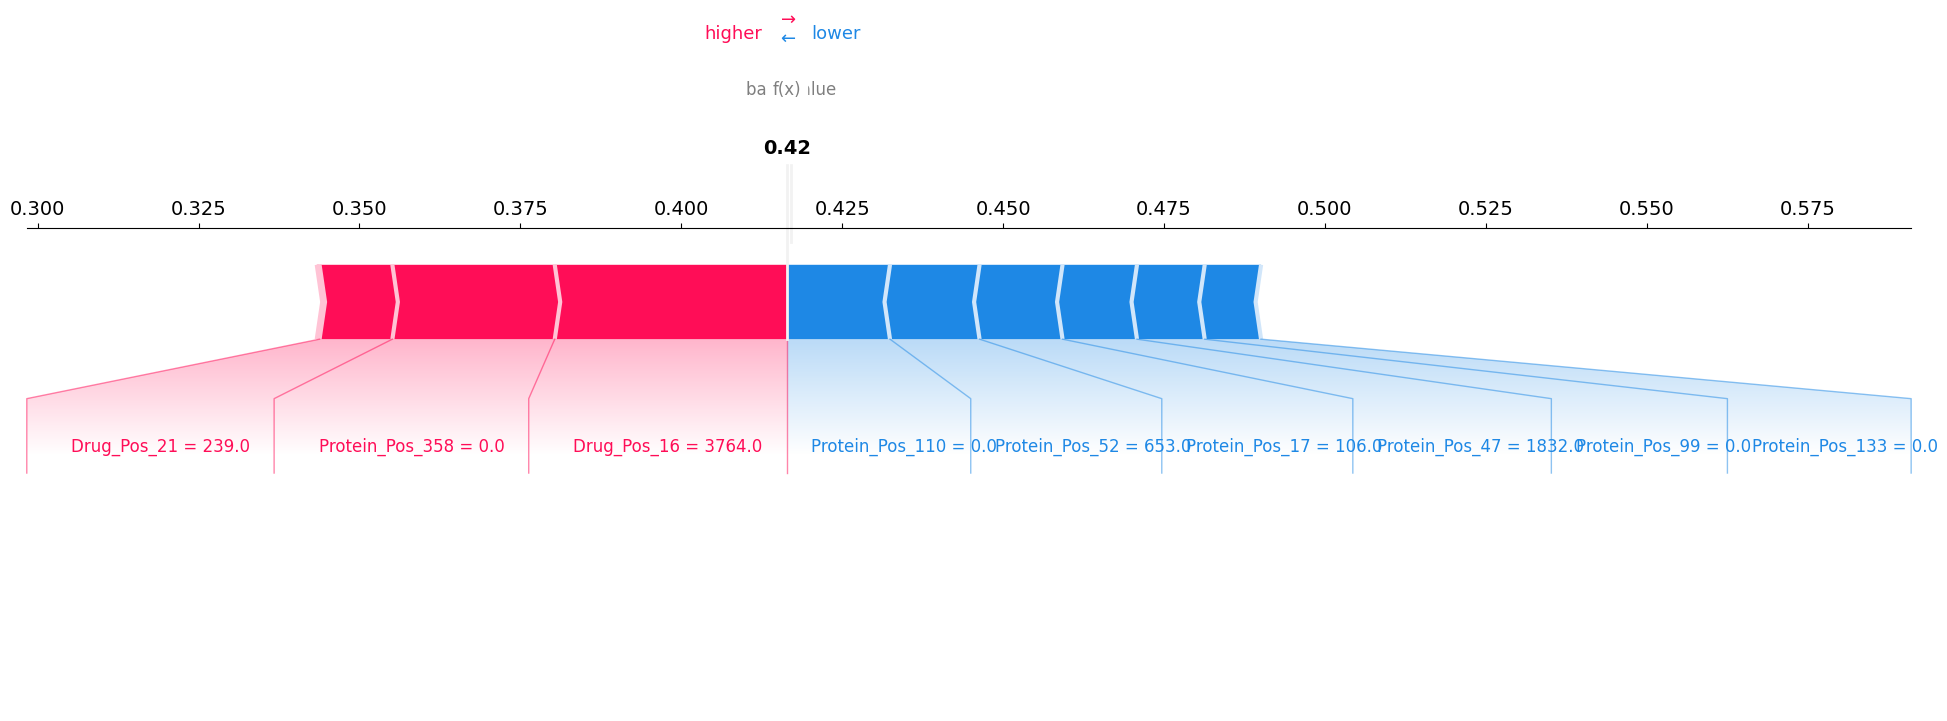

Plotting Summary Plot...


/tmp/ipykernel_1161/1138387574.py:316: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


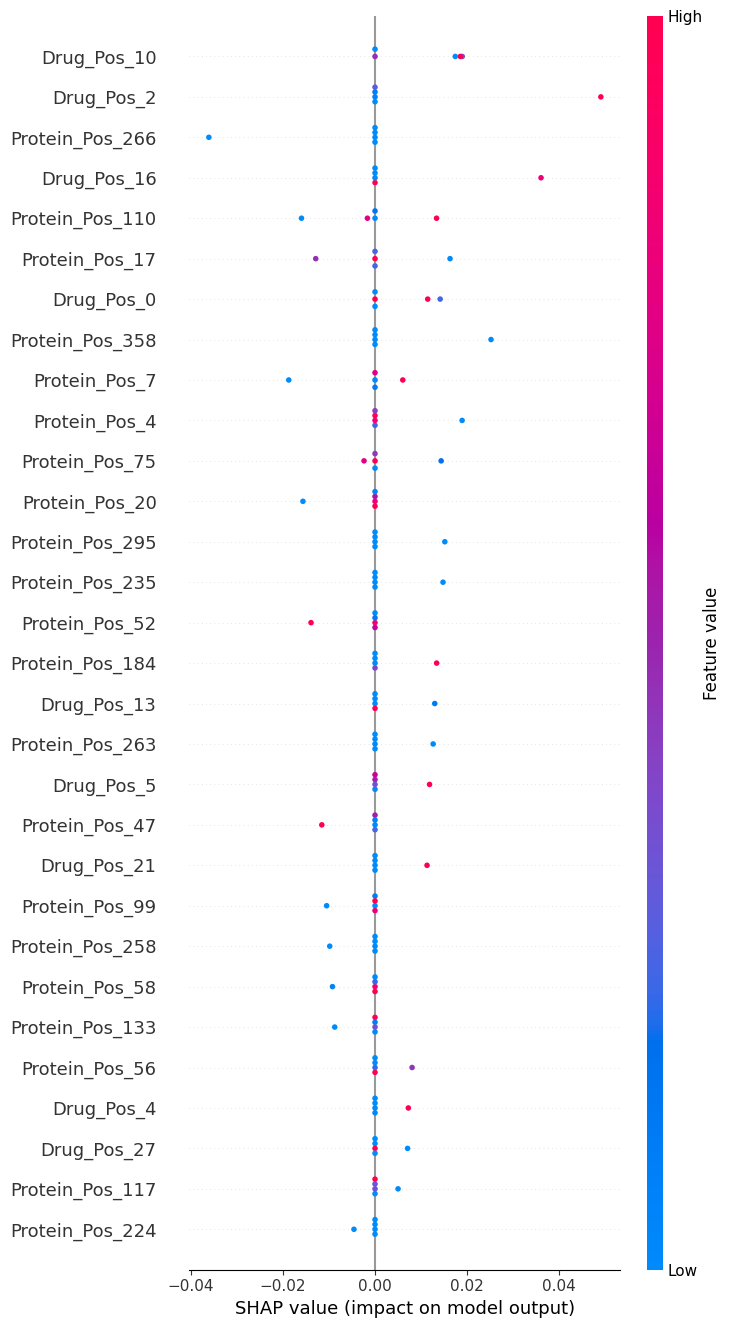

Plotting Dependency Plot...


<Figure size 1000x800 with 0 Axes>

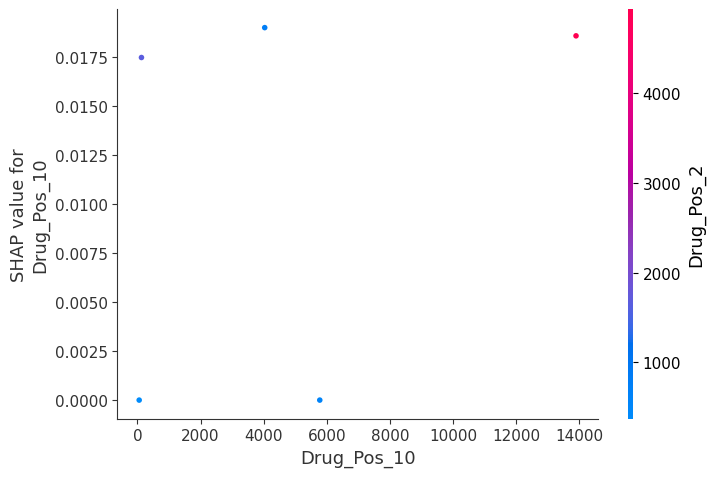

Plotting Waterfall Plot...


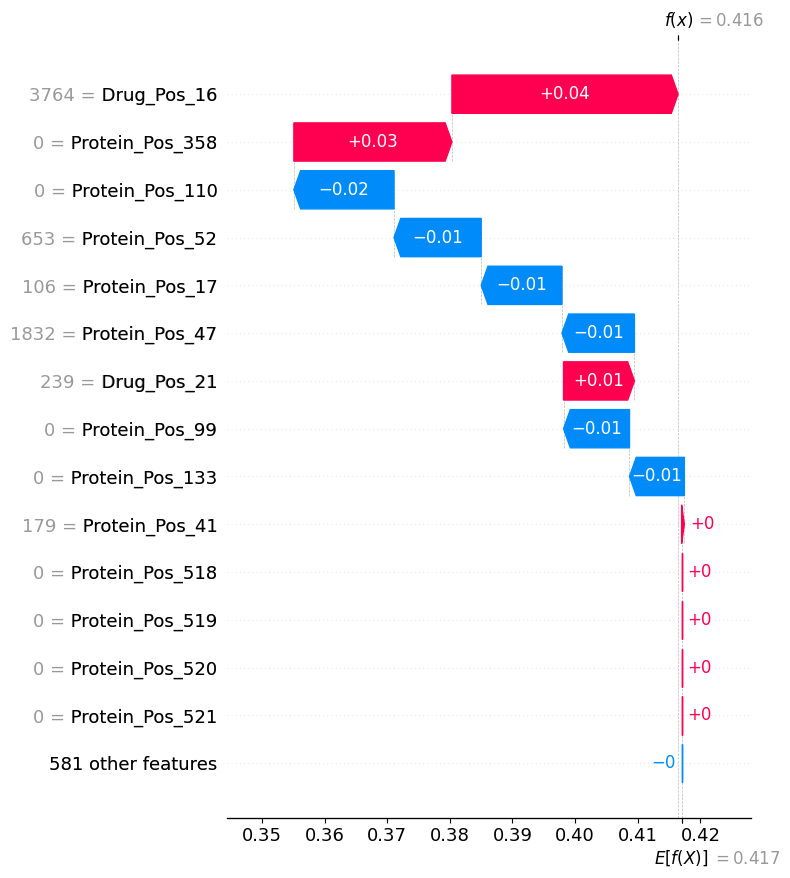

Plotting Bar Plot...


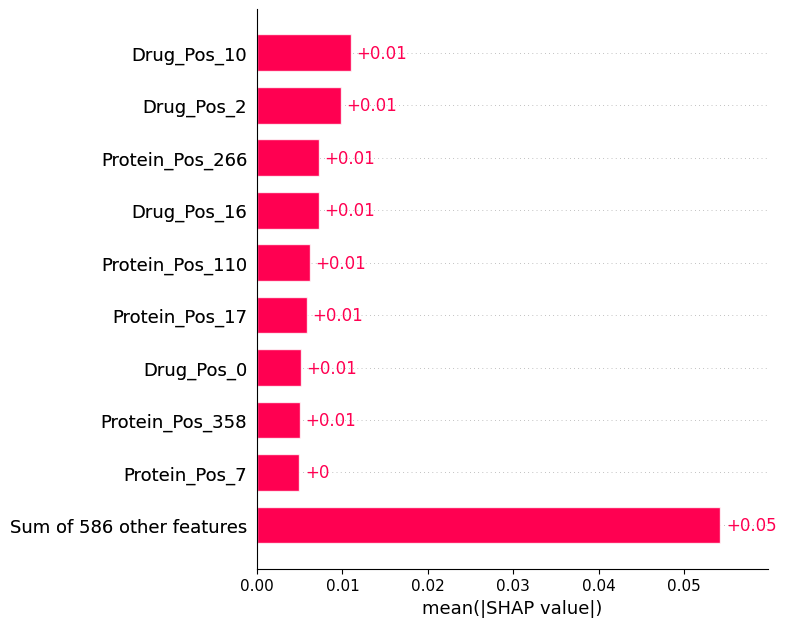

Plotting Beeswarm Plot...


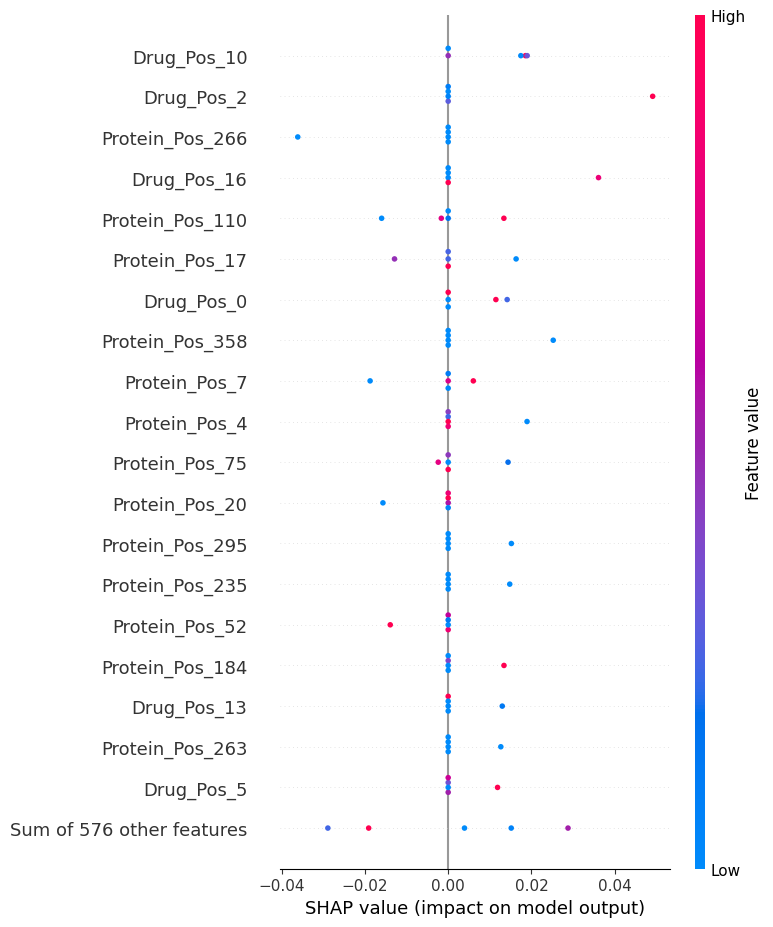


=== SHAP Analysis Statistics ===
Total number of features analyzed: 595
- Drug sequence positions: 50
- Protein sequence positions: 545
Number of samples used: 5
Top contributing drug position: Drug_Pos_10 (Mean Abs SHAP: 0.01100, Mean SHAP: 0.01100)
Top contributing protein position: Protein_Pos_0 (Mean Abs SHAP: 0.00000, Mean SHAP: 0.00000)

--- SHAP Value Distribution --- (Based on Mean SHAP Values)
Features with positive mean SHAP value: 27 (4.5%)
Features with negative mean SHAP value: 15 (2.5%)
Features with zero mean SHAP value: 553 (92.9%)
Overall mean absolute SHAP value: 0.00020
Maximum absolute SHAP value (across samples & features): 0.04911
Total calculation time: 20.07 seconds

SHAP analysis complete! All visualization charts have been saved:
1. shap_force_plot.png - Feature influence for one sample
2. shap_summary_plot.png - Overview of feature importance
3. shap_dependency_plot.png - Feature dependencies
4. shap_waterfall_plot.png - Sample feature contribution
5. shap_b

In [7]:
# Run SHAP analysis after training
# Use a small number of samples for demonstration purposes

# Make sure necessary classes and functions are imported
from stream import BIN_Data_Encoder
from config import BIN_config_DBPE

# Reload test data, as df_test is defined inside the main() function
dataFolder = get_task(args.task) # Get data folder path 
df_test = pd.read_csv(dataFolder + '/test.csv')  # Reload test data

# Use very small batch size to avoid memory issues
small_batch_size = 2  # Use smaller batch size

testing_generator = data.DataLoader(
    BIN_Data_Encoder(df_test.index, df_test.Label, df_test),
    batch_size=small_batch_size, 
    shuffle=False,
    num_workers=1,  # Reduce worker threads
    drop_last=False
)

print("Starting SHAP interpretability analysis...")
print("Note: Processing all features may take some time, please be patient...")
# Use fewer samples to speed up analysis
explainer, shap_values = shap_explainer(best_model, testing_generator, num_samples=10)
print("SHAP analysis completed!")
